In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from coba.experiments  import Experiment, Result
from coba.environments import Environments
from coba.learners     import (RandomLearner,
                               EpsilonBanditLearner,
                               VowpalEpsilonLearner,
                               VowpalRegcbLearner,
                               VowpalSquarecbLearner,
                               VowpalArgsLearner,
                               LinUCBLearner)

from learners import (IGWBanditLearner,
                      MNA_SIGWBanditLearner)

## Linear reward, no model selection

- Number of arms: 2
- Number of features: 100
- Number of interactions: 10000
- Std dev: 1/10
- Contexts are sampled from a unit sphere.
- Reward: linear

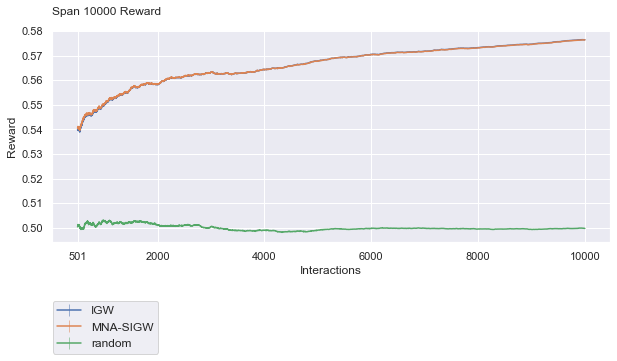

In [16]:
from typing import Sequence

from coba.random       import CobaRandom
from coba.environments import LambdaSimulation, Context, Action

np.random.seed(42)

n_actions = 2
n_context_features = 100
n_interactions = 10000
r_noise_var = 1/100

theta = np.random.normal(size=(n_actions, n_context_features))
theta = theta / np.linalg.norm(theta, axis=1, keepdims=True)

def context(index: int) -> Context:
    context = np.random.normal(size=n_context_features)
    context = context / np.linalg.norm(context)
    return tuple(context)

def actions(index: int, context: Context) -> Sequence[Action]:
    return [tuple(1 if i == j else 0 for i in range(n_actions)) for j in range(n_actions)]

def rewards(index: int, context: Context, action: Action) -> float:
    v = .5 * (np.dot(theta, np.array(context)) + 1)
    r = v[np.argmax(action)]
    e = (np.random.uniform()-.5) * np.sqrt(12) * np.sqrt(r_noise_var)
    return r + e

n_runs = 5
environments = []
for i in range(n_runs):
    environments.append(LambdaSimulation(n_interactions, context, actions, rewards))

epoch_schedule = 0
tuning_parameter = 1
do_feature_selection = False
learners     = [RandomLearner(),
                IGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection),
                MNA_SIGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection)
               ]

result = Experiment(environments, learners).evaluate("./data/paper-experiment-1.log")
result.plot_learners(sort="reward", span=n_interactions)

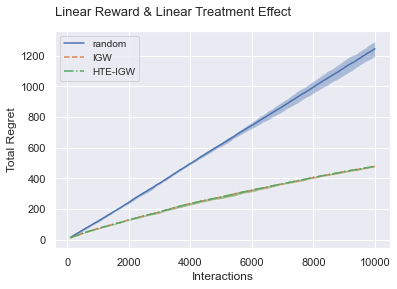

In [17]:
plt.rcParams['figure.figsize'] = [6, 4]
sns.set()
fig, ax = plt.subplots()

result = Result.from_file('./data/paper-experiment-1.log')
df = result.interactions.to_pandas()
df["regret"] = df["max_rewards"] - df["reward"]
df["regret"] = df.groupby(['environment_id', 'learner_id'])['regret'].apply(lambda x: x.expanding().sum())
df = df.groupby(['learner_id', 'index'], as_index=False).agg({'regret':['mean','std']})
df.columns = df.columns.map('_'.join)
columns = {'learner_id_':'learner_id', 'index_':'time'}
df = df.rename(columns=columns)
df

labels = ["random", "IGW", "HTE-IGW"]
ls=['-','--','-.']
for i, m in df.groupby("learner_id"):
    start = int(.01*len(m.time))
    end = int(1*len(m.time))
    # end = 5000
    ax.plot(m.time[start:end], m.regret_mean[start:end], label=labels[i], linestyle=ls[i%len(ls)])
    ax.fill_between(m.time[start:end], m.regret_mean[start:end] - 2*m.regret_std[start:end], m.regret_mean[start:end] + 2*m.regret_std[start:end], alpha=0.4)
    
ax.set_title("Linear Reward & Linear Treatment Effect", loc='left', pad=15, fontsize=13)
ax.set_ylabel("Total Regret", fontsize=12)
ax.set_xlabel("Interactions", fontsize=12)
ax.legend(fontsize=10)

plt.savefig('./data/paper-experiment-1.png', dpi=300)

## Linear reward, constant treatment effect, model selection

- Number of arms: 2
- Number of features: 100
- Number of interactions: 10000
- Std dev: 1/10
- Contexts are sampled from a unit sphere.
- Arm treatment effects (g): constant for all arms.
- Nusance function (h): Linear.

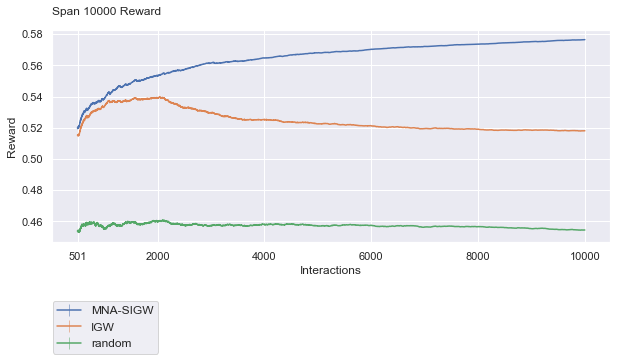

In [10]:
from typing import Sequence

from coba.random       import CobaRandom
from coba.environments import LambdaSimulation, Context, Action

np.random.seed(42)

n_actions = 2
n_context_features = 100
n_interactions = 10000
r_noise_var = 1/100

theta = np.random.normal(size=(n_context_features))
theta = theta / np.linalg.norm(theta)

onehot = np.zeros(n_actions)
onehot[0] = 1
rs = .25 * (np.random.uniform(size=(n_actions)) + onehot)

def context(index: int) -> Context:
    context = np.random.normal(size=n_context_features)
    context = context / np.linalg.norm(context)
    return tuple(context)

def actions(index: int, context: Context) -> Sequence[Action]:
    return [tuple(1 if i == j else 0 for i in range(n_actions)) for j in range(n_actions)]

def rewards(index: int, context: Context, action: Action) -> float:
    h = .25 * (np.dot(theta, np.array(context)) + 1)
    g = rs[np.argmax(action)]
    e = (np.random.uniform()-.5) * np.sqrt(12) * np.sqrt(r_noise_var)
    return h + g + e

n_runs = 5
environments = []
for i in range(n_runs):
    environments.append(LambdaSimulation(n_interactions, context, actions, rewards))

epoch_schedule = 0
tuning_parameter = 1
do_feature_selection = True
learners     = [RandomLearner(),
                IGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection),
                MNA_SIGWBanditLearner(epoch_schedule=epoch_schedule, tuning_parameter=tuning_parameter, do_feature_selection=do_feature_selection)
               ]

result = Experiment(environments, learners).evaluate("./data/paper-experiment-2.log")
result.plot_learners(sort="reward", span=n_interactions)

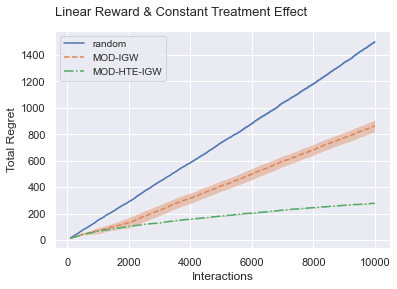

In [11]:
plt.rcParams['figure.figsize'] = [6, 4]
sns.set()
fig, ax = plt.subplots()

result = Result.from_file('./data/paper-experiment-2.log')
df = result.interactions.to_pandas()
df["regret"] = df["max_rewards"] - df["reward"]
df["regret"] = df.groupby(['environment_id', 'learner_id'])['regret'].apply(lambda x: x.expanding().sum())
df = df.groupby(['learner_id', 'index'], as_index=False).agg({'regret':['mean','std']})
df.columns = df.columns.map('_'.join)
columns = {'learner_id_':'learner_id', 'index_':'time'}
df = df.rename(columns=columns)
df

labels = ["random", "MOD-IGW", "MOD-HTE-IGW"]
ls=['-','--','-.']
for i, m in df.groupby("learner_id"):
    start = int(.01*len(m.time))
    end = int(1*len(m.time))
    ax.plot(m.time[start:end], m.regret_mean[start:end], label=labels[i], linestyle=ls[i])
    ax.fill_between(m.time[start:end], m.regret_mean[start:end] - m.regret_std[start:end], m.regret_mean[start:end] + m.regret_std[start:end], alpha=0.4)
    
ax.set_title("Linear Reward & Constant Treatment Effect", loc='left', pad=15, fontsize=13)
ax.set_ylabel("Total Regret", fontsize=12)
ax.set_xlabel("Interactions", fontsize=12)
ax.legend(fontsize=10)

plt.savefig('./data/paper-experiment-2.png', dpi=300)